### Sélection des données :
1. Trouver un jeu de données contenant au moins 5000 instances et 20
caractéris7ques (catégorielles, dates, numériques).
2. Le jeu de données doit être validé par l’enseignante avant son utilisation.

In [55]:
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [60]:
subset_size_train = 5000
subset_size_test = 2000
indices_train = np.random.choice(x_train.shape[0], subset_size_train, replace=False)
indices_test = np.random.choice(x_test.shape[0], subset_size_test, replace=False)
x_train_subset = x_train[indices_train]
y_train_subset = y_train[indices_train]
x_test_subset = x_test[indices_test]
y_test_subset = y_test[indices_test]


In [61]:

x_train_flat = x_train_subset.reshape(x_train_subset.shape[0], -1) / 255.0
x_test_flat = x_test_subset.reshape(x_test_subset.shape[0], -1) / 255.0



In [62]:
print(f"Missing values in training data: {np.isnan(x_train_flat).sum()}")
print(f"Missing values in test data: {np.isnan(x_test_flat).sum()}")


Missing values in training data: 0
Missing values in test data: 0


In [63]:
top_features = feature_df.index[:500]  # Select indices of top 500 features
x_train_top = x_train_flat[:, top_features]
x_test_top = x_test_flat[:, top_features]
print(f"Reduced training shape: {x_train_top.shape}, Reduced test shape: {x_test_top.shape}")

Reduced training shape: (5000, 500), Reduced test shape: (2000, 500)


In [64]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())

# Output best parameters and cross-validated accuracy
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated accuracy: 0.3807981500938708


In [65]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [None, 10, 20 , 30],
    'min_samples_split': [2, 5 , 10],
    'min_samples_leaf': [1, 2 , 4]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())

# Output best parameters and cross-validated accuracy
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best cross-validated accuracy: 0.3843992305980581


In [66]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(x_test_top)
cm = confusion_matrix(y_test_subset.ravel(), y_pred)



In [68]:
feature_importances = best_rf.feature_importances_
feature_df = pd.DataFrame({
    "Feature": [f"pixel_{i}" for i in range(len(feature_importances))],
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print(feature_df.head(20))

       Feature  Importance
155  pixel_155    0.002932
213  pixel_213    0.002860
300  pixel_300    0.002765
410  pixel_410    0.002733
345  pixel_345    0.002721
361  pixel_361    0.002684
222  pixel_222    0.002669
443  pixel_443    0.002627
2      pixel_2    0.002617
356  pixel_356    0.002607
432  pixel_432    0.002593
427  pixel_427    0.002552
240  pixel_240    0.002550
321  pixel_321    0.002540
221  pixel_221    0.002536
111  pixel_111    0.002529
409  pixel_409    0.002520
65    pixel_65    0.002487
425  pixel_425    0.002450
315  pixel_315    0.002450


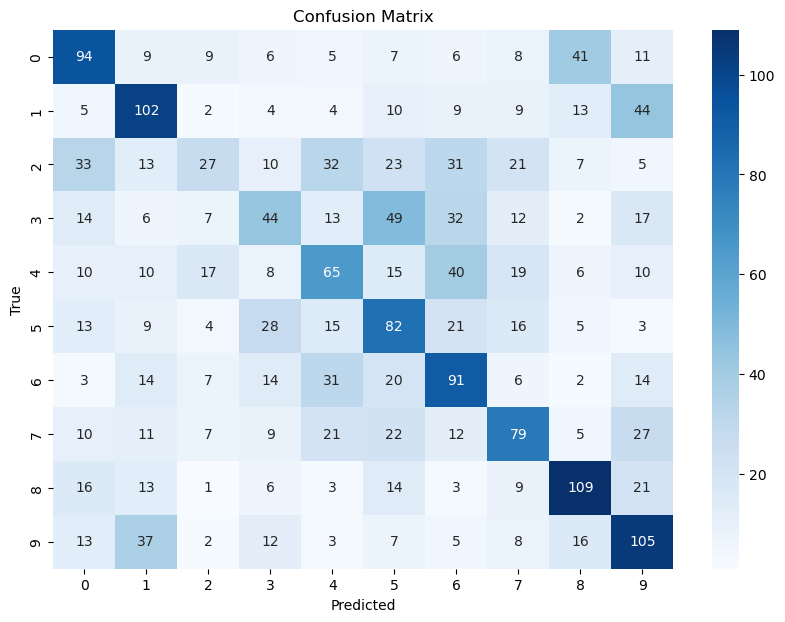

In [67]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [69]:
# Classification report
print(classification_report(y_test_subset.ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.45      0.48      0.46       196
           1       0.46      0.50      0.48       202
           2       0.33      0.13      0.19       202
           3       0.31      0.22      0.26       196
           4       0.34      0.33      0.33       200
           5       0.33      0.42      0.37       196
           6       0.36      0.45      0.40       202
           7       0.42      0.39      0.41       203
           8       0.53      0.56      0.54       195
           9       0.41      0.50      0.45       208

    accuracy                           0.40      2000
   macro avg       0.39      0.40      0.39      2000
weighted avg       0.39      0.40      0.39      2000



In [70]:
# ROC-AUC score (One-vs-Rest)
y_pred_proba = best_rf.predict_proba(x_test_top)
auc_score = roc_auc_score(y_test_subset, y_pred_proba, multi_class='ovr')
print(f"Multiclass AUC (OvR): {auc_score:.4f}")

Multiclass AUC (OvR): 0.8209
